In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from io import StringIO 
import chardet
import jieba
import cpca
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from collections import Counter
import re
from cpca import drawer
import zh_core_web_sm
import scattertext as st
nlp = zh_core_web_sm.load()

In [3]:
from pylab import *
import matplotlib.pyplot as plt
# plt图像上显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题

In [4]:
#判断文件编码类型
f = open("weibo_user.csv",'rb')
data = f.read()
print(chardet.detect(data))

{'encoding': 'GB2312', 'confidence': 0.99, 'language': 'Chinese'}


In [6]:
#由于weibo_user和user_post无法用read_csv正常打开，故使用open进行操作
weibo_user = open("weibo_user.csv",'r',encoding="gb18030",errors='ignore')
weibo_user = pd.read_csv(StringIO(weibo_user.read()), delimiter=",")
#weibo_user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       781 non-null    int64  
 1   user_name     781 non-null    object 
 2   user_image    781 non-null    object 
 3   gender        781 non-null    object 
 4   class         781 non-null    int64  
 5   message       780 non-null    object 
 6   post_num      781 non-null    int64  
 7   follower_num  781 non-null    int64  
 8   followee_num  781 non-null    int64  
 9   is_spammer    179 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 61.1+ KB


## weibo_user

In [6]:
#对weibo_user进行处理
weibo_user = weibo_user.drop (['user_image'],axis = 1)
weibo_user['is_spammer'] =weibo_user['is_spammer'].fillna('0')
weibo_user['is_spammer'].value_counts()

0       602
1.0     113
-1.0     66
Name: is_spammer, dtype: int64

In [7]:
#可以看到is_spammer中-1的内容仅占了不到9%，故在后续数据的处理中直接将其删除
weibo_user=weibo_user[~weibo_user['is_spammer'].isin([-1.0])]

In [8]:
weibo_user=weibo_user.dropna()
weibo_user.gender[weibo_user['gender']=='male']= 1
weibo_user.gender[weibo_user['gender']=='female']= 0
#weibo_user.info()

In [9]:
weibo_user['gender']=pd.to_numeric(weibo_user['gender'])
weibo_user['is_spammer']=pd.to_numeric(weibo_user['is_spammer'])
spammer=weibo_user[weibo_user['is_spammer']==1.0]
no_spammer=weibo_user[weibo_user['is_spammer']==0.0]

In [10]:
intro=weibo_user[['is_spammer','message']]
intro['is_spammer'] = intro['is_spammer'].astype(str)

In [11]:
corpus = st.CorpusFromPandas(intro, category_col='is_spammer', text_col='message', nlp=nlp).build()

In [12]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['no_spammer'] = corpus.get_scaled_f_scores('0.0')
No_Spammer_most = list(term_freq_df.sort_values(by='no_spammer',ascending=False).index[:10])
print(No_Spammer_most)

['苏州', 'ˇ ????', '关注', '厦门', '殑', '悕', '之', '爱', '江苏 苏州', '企业']


In [13]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['is_spammer'] = corpus.get_scaled_f_scores('1.0')
No_Spammer_most = list(term_freq_df.sort_values(by='is_spammer',ascending=False).index[:10])
print(No_Spammer_most)

['糗事', '开始', '河南 商丘', '代购', '商丘', '真正', '人群', '挖掘', '精准', '数据']


In [14]:
html = st.produce_scattertext_explorer(corpus, category='0.0', category_name='No_Spammer', not_category_name='Is_Spammer',
                                      width_in_pixels=1000)
open("./intro.html",'wb').write(html.encode('utf-8'))

539837

In [15]:
pd.DataFrame(no_spammer['message']).to_csv("no_spammer.csv", index=False,encoding = "gb18030")
pd.DataFrame(spammer['message']).to_csv("spammer.csv", index=False,encoding = "gb18030")

In [16]:
#使用cpca查看非垃圾邮件id的地理分布情况
with open("no_spammer.csv", "r", encoding='gb18030',errors='ignore') as f:
    string = f.read()
locations = cpca.transform_text_with_addrs(string)
drawer.draw_locations(locations[cpca._ADCODE], "no_spammer.html")

#使用cpca查看垃圾邮件id的地理分布情况
with open("spammer.csv", "r", encoding='gb18030',errors='ignore') as f:
    string = f.read()
locations = cpca.transform_text_with_addrs(string)
from cpca import drawer
drawer.draw_locations(locations[cpca._ADCODE], "spammer.html")

In [17]:
data = weibo_user[['class','gender','post_num','follower_num','followee_num','is_spammer']]
#作相关系数矩阵，即给出了任意两个标签之间的相关系数
corr_linear=data.corr()
#计算spearman，kendall相关系数
corr_spearman=data.corr('spearman') 
corr_kendall=data.corr('kendall')

C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'corr_linear'}>

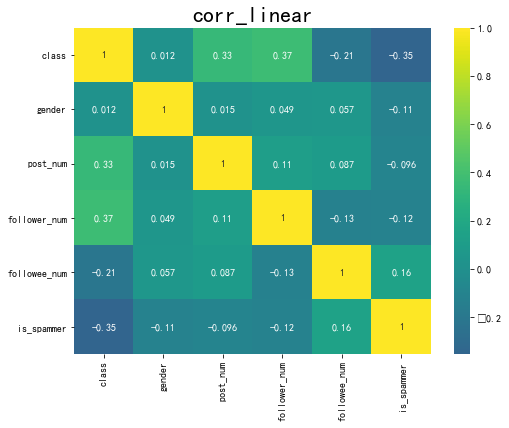

In [18]:
plt.figure(figsize=(8,6))
plt.title('corr_linear', fontsize=22)
sns.heatmap(corr_linear,cmap='viridis', center=0, annot=True) 

<AxesSubplot:title={'center':'corr_spearman'}>

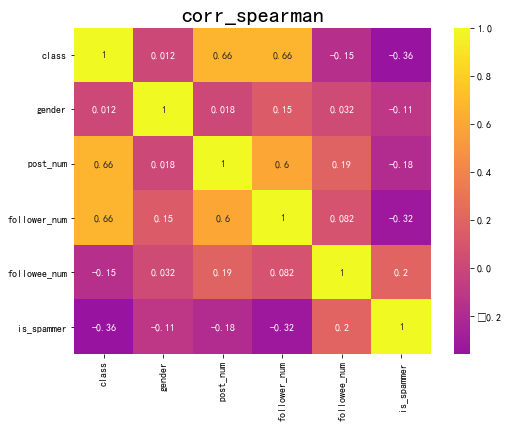

In [19]:
plt.figure(figsize=(8,6))
plt.title('corr_spearman', fontsize=22)
sns.heatmap(corr_spearman,cmap='plasma', center=0, annot=True) 

<AxesSubplot:title={'center':'corr_kendall'}>

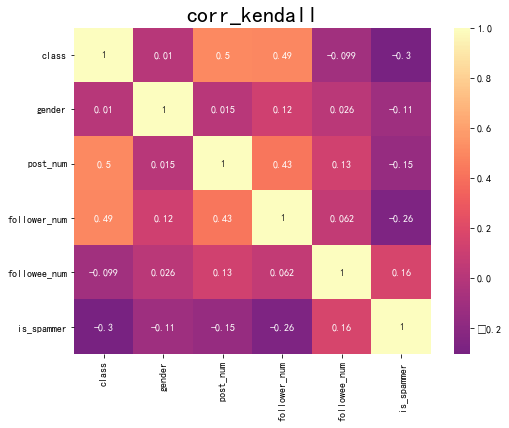

In [20]:
plt.figure(figsize=(8,6))
plt.title('corr_kendall', fontsize=22)
sns.heatmap(corr_kendall,cmap='magma', center=0, annot=True) 

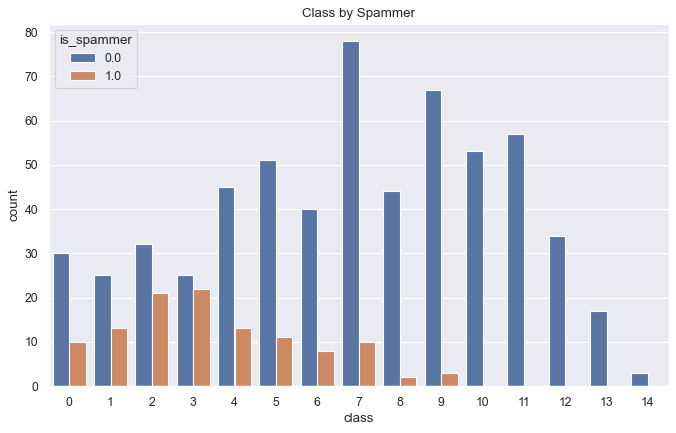

In [38]:
plt.figure(figsize=(10,6), dpi= 80)
sns.set(style="darkgrid")
sns.countplot(x="class", hue="is_spammer", data=data)
plt.title('Class by Spammer')
plt.show()

<Figure size 1200x800 with 0 Axes>

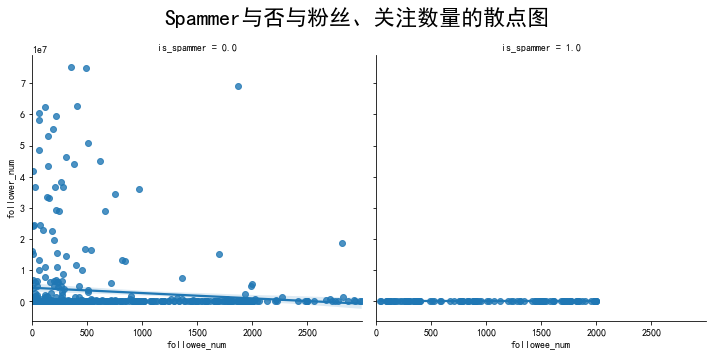

In [34]:
# Plot矩阵图
plt.figure(dpi= 200)
pic = sns.lmplot( x= 'followee_num', y='follower_num', data=data, palette='Set1', col="is_spammer", 
           col_wrap=2)

# Decorations
plt.suptitle("Spammer与否与粉丝、关注数量的散点图", fontsize=22)
plt.tight_layout()
plt.show()

In [36]:
data=data.astype(int)
#data.head()

C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 800x640 with 0 Axes>

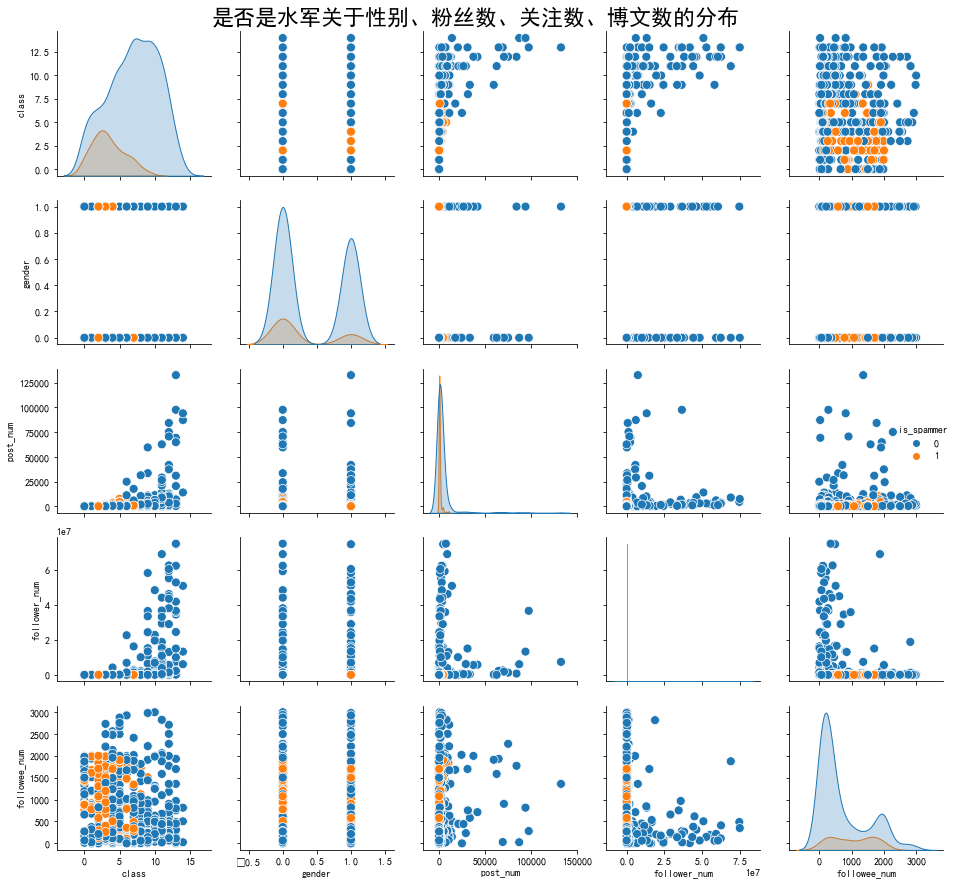

In [37]:
# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(data, kind="scatter", hue='is_spammer', plot_kws=dict(s=80))
plt.suptitle("是否是水军关于性别、粉丝数、关注数、博文数的分布", fontsize=22)
plt.tight_layout()
plt.show()

In [38]:
spammer_counts=spammer['gender'].value_counts()
labels1 = spammer_counts.index
no_spammer_counts=no_spammer['gender'].value_counts()
labels2 = no_spammer_counts.index

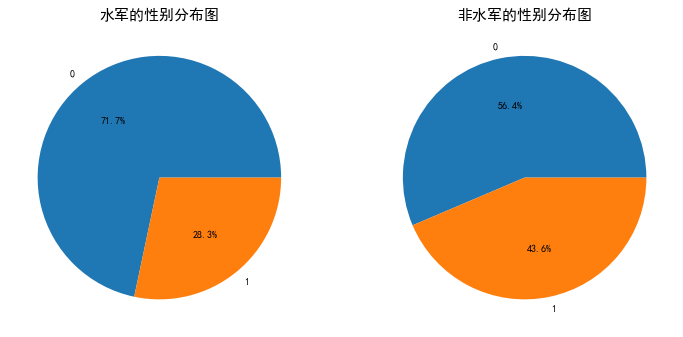

In [39]:
#绘制性别比例图
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pie(spammer_counts,labels = labels1, autopct = '%1.1f%%',shadow= False)
plt.title('水军的性别分布图',fontsize=15)
plt.subplot(122)
plt.pie(no_spammer_counts,labels = labels2, autopct = '%1.1f%%',shadow= False)
plt.title('非水军的性别分布图',fontsize=15)
plt.show()

## follower_followee

In [7]:
#可以看到文件99%的编码类型都是GB2312，故本处使用GB2312、gb18030、gbk的方式解码数据
#对数据简单观察后可以发现，post及文件中post_id列使用了科学计数法的表示方法，无法显示真实数据，故此处导入的post及user_post是对其进行数值处理后的数据
follower_followee = pd.read_csv("follower_followee.csv",encoding="gbk")
follower_followee=follower_followee.dropna()
follower_followee.head()

id        follower  follower_id followee followee_id  guanzhu  fensi  \
0  169270        积奇薄荷少女怀亦   5331917298     新百伦商  2364770064     1415     49   
1  169271      淑女superman   5372497984     新百伦商  2364770064       67      4   
2  169272      数据老南瓜627寒雁   5322066783     新百伦商  2364770064     1501     58   
3  169273            仁者本善   5063358893     新百伦商  2364770064     1583    104   
4  169274  painfulresul的家   3975927245     新百伦商  2364770064     1442     45   

   post_num  gender first_or_last  
0        33  female         first  
1         1  female         first  
2        34    male         first  
3       179  female         first  
4       108  female         first

In [8]:
follower_followee = follower_followee.drop (['first_or_last','id'],axis = 1)
follower_followee.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142184 entries, 0 to 142367
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   follower     142184 non-null  object
 1   follower_id  142184 non-null  int64 
 2   followee     142184 non-null  object
 3   followee_id  142184 non-null  object
 4   guanzhu      142184 non-null  int64 
 5   fensi        142184 non-null  int64 
 6   post_num     142184 non-null  int64 
 7   gender       142184 non-null  object
dtypes: int64(4), object(4)
memory usage: 9.8+ MB


In [42]:
#将follower_followee和no_spammer的user表格按id合并
data1=follower_followee[['follower_id','followee','followee_id']]
data_no= pd.merge(no_spammer,data1,how='left',left_on='user_id',right_on='follower_id',sort=False)
data_is=pd.merge(spammer,data1,how='left',left_on='user_id',right_on='follower_id',sort=False)
#data_no.info()

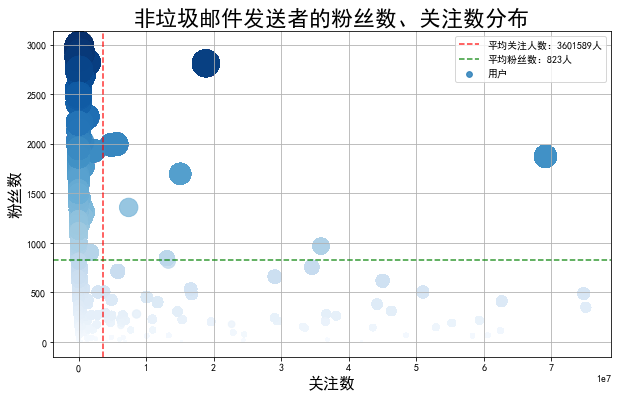

In [43]:
#data_no粉丝和关注数
plt.figure(figsize=(10,6))
guanzhu = data_no['follower_num']
fensi = data_no['followee_num']
guanzhu_mean = data_no['follower_num'].mean()
fans_mean = data_no['followee_num'].mean()
plt.scatter(guanzhu,fensi,marker='.',s = fensi, cmap = 'Blues', c = fensi, alpha=0.8,label = '用户')
plt.axvline(guanzhu_mean,label="平均关注人数：%i人" % guanzhu_mean,color='r',linestyle="--",alpha=0.8)  
plt.axhline(fans_mean,label="平均粉丝数：%i人" % fans_mean,color='g',linestyle="--",alpha=0.8)   
plt.legend(loc = 'upper right',markerscale=0.3)
plt.title('非垃圾邮件发送者的粉丝数、关注数分布', fontsize=22)
plt.xlabel('关注数', fontsize=16)
plt.ylabel('粉丝数', fontsize=16)
plt.grid()

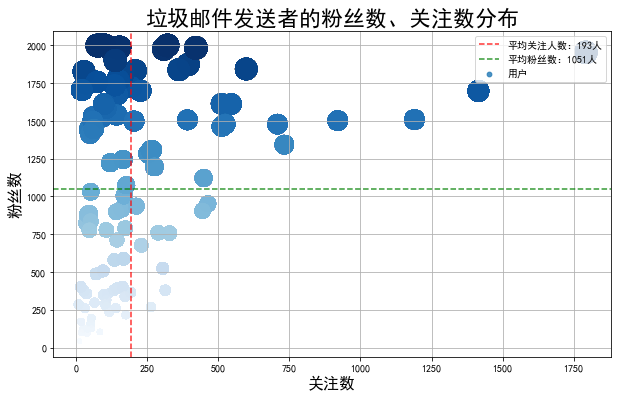

In [45]:
#data_is粉丝和关注数
plt.figure(figsize=(10,6))
guanzhu = data_is['follower_num']
fensi = data_is['followee_num']
guanzhu_mean = data_is['follower_num'].mean()
fans_mean = data_is['followee_num'].mean()
plt.scatter(guanzhu,fensi,marker='.',s = fensi, cmap = 'Blues', c = fensi, alpha=0.8,label = '用户')
plt.axvline(guanzhu_mean,label="平均关注人数：%i人" % guanzhu_mean,color='r',linestyle="--",alpha=0.8)  
plt.axhline(fans_mean,label="平均粉丝数：%i人" % fans_mean,color='g',linestyle="--",alpha=0.8)   
plt.legend(loc = 'upper right',markerscale=0.3)
plt.title('垃圾邮件发送者的粉丝数、关注数分布', fontsize=22)
plt.xlabel('关注数', fontsize=16)
plt.ylabel('粉丝数', fontsize=16)
plt.grid()

In [43]:
#relation=data1
#relation.info()

In [46]:
data_is=data_is[['user_id','user_name','followee','followee_id']]
#data_is = data_is.drop_duplicates()
#data_is.info()

In [101]:
count_is = data_is['followee'].value_counts()
count_is=count_is[count_is>=7]

In [102]:
count_is

孚禾静静_           48
新百伦商            20
潘凤              19
最新影视推           15
新百伦商城           13
她人之梦sunshine    11
微博Android客户端     8
微博赛事             7
微博游戏中心           7
潘凤才              7
窜撒呀布拉            7
Name: followee, dtype: int64

Text(0, 0.5, '数量')

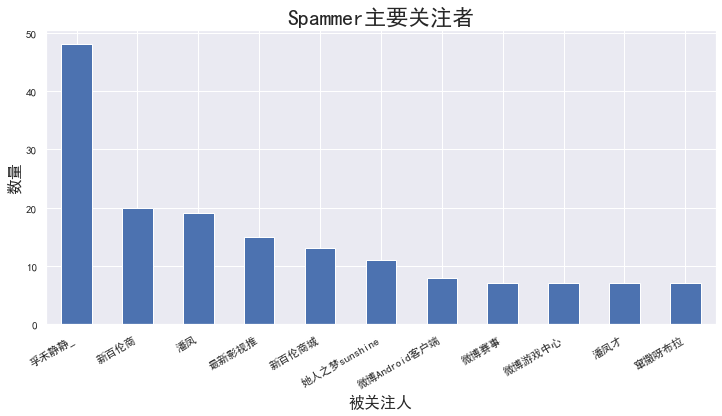

In [116]:
fig=plt.figure()
count_is.plot(x=count_is.index, y=count_is, kind="bar",figsize=(12,6))
fig.autofmt_xdate() #自动旋转xlabel
plt.title('Spammer主要关注者', fontsize=22)
plt.xlabel('被关注人', fontsize=16)
plt.ylabel('数量', fontsize=16)

In [111]:
count_no = data_no['followee'].value_counts()
count_no=count_no[count_no>=36]

孚禾静静_           122
她人之梦sunshine     95
微博赛事             73
潘凤               63
微博游戏中心           61
范冰冰              46
杨幂               44
新百伦商             41
谢娜               39
央视新闻             38
Name: followee, dtype: int64

Text(0, 0.5, '数量')

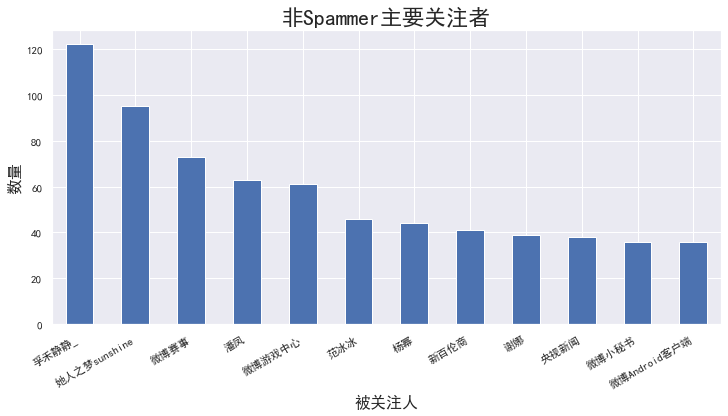

In [117]:
fig=plt.figure()
count_no.plot(x=count_no.index, y=count_no, kind="bar",figsize=(12,6))
fig.autofmt_xdate() #自动旋转xlabel
plt.title('非Spammer主要关注者', fontsize=22)
plt.xlabel('被关注人', fontsize=16)
plt.ylabel('数量', fontsize=16)

In [118]:
#Spammer的关系图
d_is = pd.DataFrame(data_is['followee_id'].value_counts())
d_is.columns = ['nums']
d_is = d_is[d_is['nums'] <=1]
delindexs = d_is.index
print(len(delindexs))

8805


In [119]:
data_is = data_is[~data_is['followee_id'].isin(delindexs)]
data_is.to_csv("data_is.csv", index=False,encoding = "gb18030")
#data_is.info()

In [120]:
#不是spammer的关系图
d = pd.DataFrame(data_no['followee'].value_counts())
d.columns = ['nums']
d = d[d['nums'] <=4]
delindexs = d.index
print(len(delindexs))

40443


In [121]:
data_no = data_no[~data_no['followee'].isin(delindexs)]
#data_no.info()

In [122]:
d = pd.DataFrame(data_no['user_id'].value_counts())
d.columns = ['nums']
d = d[d['nums'] <=10]
delindexs = d.index
print(len(delindexs))

286


In [123]:
data_no = data_no[~data_no['user_id'].isin(delindexs)]
#data_no.info()

In [124]:
data_no=data_no[['user_id','user_name','followee','followee_id']]
data_no=data_no.rename(columns= {'user_id':'Source','followee':'Target'})
data_no.to_csv("data_no.csv", index=False,encoding = "gb18030")

## post

In [45]:
post = pd.read_csv("post.csv",encoding="GB2312")
#post.head()

In [46]:
content= post['content']

In [47]:
remove_words = [u'的', u'，',u'和', u'是', u'?', u'对于', u'对',u'等',u'于',u'都',u'。',u' ',u'、',u'中',u'在',u'了',
                u'也',u'：',u'我们',u'【',u'】',u'/',u'！',u'|',u'…'] # 自定义去除词库
message_cut = content.apply(lambda x : [i for i in jieba.cut(x) if i not in remove_words])
#message_cut.head(15)

Building prefix dict from the default dictionary ...
Loading model from cache Z:\TEMP\jieba.cache
Loading model cost 0.597 seconds.
Prefix dict has been built successfully.


0     [爆美来, 袭, 独家, 实拍, 质量, 看, 见, 招微信, 代理, 一件, 代发, 专卖...
1     [奥汀羽, 酵素, 反馈, 效果, 不好, 不会, 卖, 这么, 好, 正常, 吃饭, 不用...
2     [我, 有, 话, 说, 世界, 最穷, 总统, 拒绝, 酋长, 高价, 收购, 其老旧, ...
3     [蚕丝, 皂, 吸附, 黑头, 能力, 一级, 棒, 清洁, 不选, 它, 你, 没, 眼光...
4     [我活, 得, 很, 好, 世界, 最穷, 总统, 拒绝, 酋长, 高价, 收购, 其老旧,...
5                                          [世界, 最穷, 总统]
6     [世界, 最穷, 总统, 脸部, 保养, 大全, 去, 黑头, 祛斑, 去, 痘, 去, 眼...
7     [连发, 一禾, 三生, 反馈, 好, 东西, 就是, 卖出去, 一个, 就, 会, 有, ...
8     [致敬, 世界, 最穷, 总统, 拒绝, 卖车, 致富, 世界, 最穷, 总统, 拒绝, 酋...
9                      [史上, 最牛, 请假条, 号称, 世界, 上, 最穷, 总统]
10    [一禾, 三生, 反馈, 用, 一次, 头发, 顺, 坚持, 使用, 发质, 问题, 全没,...
11    [世界, 最穷, 总统, 住, 板房, 保镖, 仅, 两名, 警察, 一条, 狗, （, 图...
12               [世界, 最穷, 总统, 亲吻, 女人, 9, 大, 部位, 不同, 感受]
13    [奥汀羽, 酵素, 暴力, 反馈, 十月, 中旬, 到, 现在, 瘦, 16, 斤, 从小,...
14    [俺, 向, 他, 致以, 崇高, 敬意, 世界, 最穷, 总统, 拒绝, 酋长, 高价, ...
Name: content, dtype: object

In [48]:
message_cut=pd.DataFrame(message_cut)
message_cut.to_csv('clean.txt',index=False,sep=' ',encoding='gbk',errors='ignore')

In [49]:
#设置词云
from wordcloud import WordCloud
wc = WordCloud(background_color = "white", #设置背景颜色
               max_words =100, #设置最大显示的字数
               #stopwords = "", #设置停用词
               font_path = "STKAITI.TTF",
        #设置中文字体，使得词云可以显示（词云默认字体是“DroidSansMono.ttf字体库”，不支持中文）
               max_font_size = 50,  #设置字体最大值
               random_state = 30, #设置有多少种随机生成状态，即有多少种配色方案
               width=500, height=250
    )

In [50]:
text = open("clean.txt","rb").read()
wordlist = jieba.cut(text, cut_all = False) # 精确模式分词
words= []
remove_words = [u'的', u'，',u'和', u'是', u'随着', u'对于', u'对',u'等',u'能',u'都',u'。',u' ',u'、',u'中',u'在',u'了',
                u'通常',u'如果',u'我们',u'需要'] # 自定义去除词库
for word in wordlist: # 循环读出每个分词
    if word not in remove_words: # 如果不在去除词库中
        words.append(word) # 分词追加到列表

In [51]:
words = " ".join(words)
myword = wc.generate(words)#生成词云

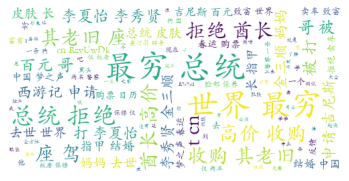

In [52]:
plt.imshow(myword)
plt.axis("off")
plt.show()
#wc.to_file('京东.png')  # 把词云保存下来 

## user_post

In [9]:
user_post = open("user_post.csv",'r',encoding="gb18030",errors='ignore')
user_post = pd.read_csv(StringIO(user_post.read()), delimiter=",")
#ser_post.head()

In [10]:
user_post= user_post.drop(['post_id','poster_url','repost_post_id','inner_flag'],axis=1)
user_post=user_post.dropna()
user_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39476 entries, 0 to 48812
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_time    39476 non-null  object 
 1   content      39476 non-null  object 
 2   poster_id    39476 non-null  float64
 3   repost_num   39476 non-null  float64
 4   comment_num  39476 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.8+ MB


In [141]:
#对短信中的用户名前缀和内部的url链接进行过滤删除
#前缀的正则
username_regex = re.compile(r"^\d+::")
#URL，为了防止对中文的过滤，所以使用[a-zA-Z0-9]而不是\w
url_regex = re.compile(r"""
    (https?://)?
    ([a-zA-Z0-9]+)
    (\.[a-zA-Z0-9]+)
    (\.[a-zA-Z0-9]+)*
    (/[a-zA-Z0-9]+)*
""", re.VERBOSE|re.IGNORECASE)
#剔除日期
data_regex = re.compile(u"""        #utf-8编码
    年 |
    月 |
    日 |
    (周一) |
    (周二) | 
    (周三) | 
    (周四) | 
    (周五) | 
    (周六)
""", re.VERBOSE)
#剔除空格
space_regex = re.compile(r"\s+")
#剔除特殊符号
doc_regex = re.compile(r"`~!@#$@%^&*//()_\-+=<>？:\"\{}|,.\/;'\\\[\]·~！@#￥%……&*（）——\-+={}|《》？：“”【】、；‘’，。、")

In [142]:
def clear1(data): 
    return doc_regex.sub('', data)
def clear2(data): 
    return username_regex.sub('', data)
def clear3(data): 
    return data_regex.sub('', data)
def clear4(data): 
    return url_regex.sub('', data)

In [143]:
user_post['content'] = user_post['content'].apply(clear1)
user_post['content'] = user_post['content'].apply(clear2)
user_post['content'] = user_post['content'].apply(clear3)
user_post['content'] = user_post['content'].apply(clear4)

In [144]:
dataset= pd.merge(weibo_user,user_post,how='right',left_on='user_id',right_on='poster_id',sort=False)
dataset=dataset[['user_id','user_name','post_time','is_spammer','content','repost_num','comment_num']]
#dataset.info()

In [146]:
num=dataset[['is_spammer','repost_num','comment_num']]
num=num.dropna()

<Figure size 800x640 with 0 Axes>

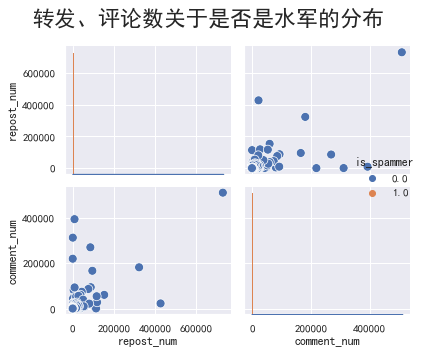

In [151]:
# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(num, kind="scatter", hue='is_spammer', plot_kws=dict(s=80))
plt.suptitle("转发、评论数关于是否是水军的分布", fontsize=22)
plt.tight_layout()
plt.show()

In [132]:
data_1 = dataset[['is_spammer','content']]
data_1['is_spammer'].fillna(2, inplace=True)

In [133]:
dataset=dataset.dropna(subset=['content','is_spammer'])
#dataset.info()

In [134]:
# 改成spammer与否的两个密度图
post_time=dataset['post_time']
post_time.index = range(len(post_time))
post_time =pd.DataFrame(post_time)
post_time=post_time.dropna()

In [135]:
time = post_time["post_time"].str.cat([' '] * len(post_time))
for i in range(len(time)):
    a=str(time[i])
    b =  datetime.datetime.strptime(a, "%Y/%m/%d %H:%M ")
    b=b.timestamp()
    time[i]=b

In [136]:
data_2=dataset[['post_time','is_spammer']]
data_2['post_time'] = pd.DataFrame(time)
data_2=data_2.dropna()
data_2['post_time'] = data_2['post_time'].astype(float)
#data_2.head()

In [137]:
#original = post_time["post_time"].str.cat([' '] * len(post_time))
#original=original.sort_values(ascending = True)
#original.index = range(len(original))

C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\JYZ\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


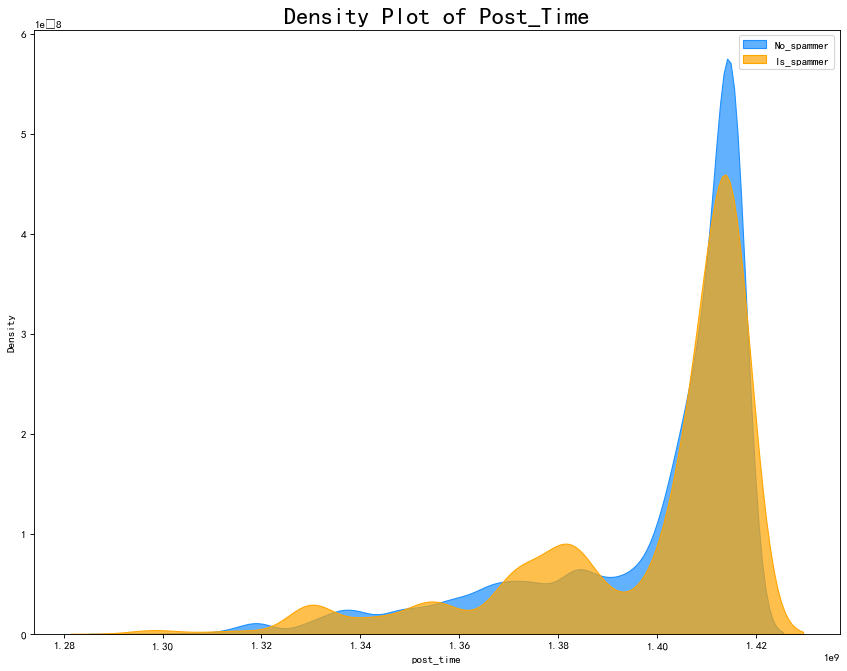

In [66]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
#ax = plt.subplot(111)              
plt.figure(figsize=(13,10), dpi= 80)
sns.kdeplot(data_2.loc[data_2['is_spammer'] == 0.0 ,'post_time'], shade=True, color="dodgerblue", label='No_spammer', alpha=.7)
sns.kdeplot(data_2.loc[data_2['is_spammer'] == 1.0 ,'post_time'], shade=True, color="orange", label="Is_spammer", alpha=.7)
#xmajorLocator   = MultipleLocator(20000000) #将x主刻度标签设置为n的倍数
#ax.xaxis.set_major_locator(xmajorLocator)
#plt.xticks(time,original,rotation=30)
# Decoration
plt.title('Density Plot of Post_Time', fontsize=22)
plt.legend()
plt.show()

In [152]:
content=dataset[['content','is_spammer','user_name']]
#content.info()
#content['is_spammer'].value_counts()

In [153]:
content_1=content[content['is_spammer']==1.0]
content_0=content[content['is_spammer']==0.0]
content_0 = content_0.sample(n=10000)
final =pd.concat([content_0,content_1])

In [154]:
#final.info()

In [157]:
import texthero as hero
final['pca'] = (
        final['content']
            .pipe(hero.clean)
            .pipe(hero.tfidf)
            .pipe(hero.pca)
        )

In [158]:
hero.scatterplot(final, col='pca', color='is_spammer',title="微博内容的PCA图")

In [159]:
NUM_TOP_WORDS = 5
final.groupby('is_spammer')['content'].apply(lambda x: hero.top_words(x)[:NUM_TOP_WORDS])

is_spammer                                                                
0.0         转发微博                                                              1250
            ~                                                                   66
            分享图片                                                                42
            体育女主播完全可以穿比基尼主持节目澳洲更有全裸女主播我们为什么不可以有呢《体育新闻》女主播私房照httptcn8s6zlOx      26
            ~~                                                                  25
1.0         转发微博                                                               685
            超级低音专享天籁之声httptcn8sri95S                                            42
            超级低音专享天籁之声httptcn8skIEB0                                            39
            2014NewBalance新百伦NB574纽巴伦httptcn8skYngS                             38
            普拉达PRADA钱包httptcn8sriIRX                                            37
Name: content, dtype: int64

In [160]:
#content.head()
content['is_spammer'] = content['is_spammer'].astype(str)

In [161]:
corpus = st.CorpusFromPandas(content, category_col='is_spammer', text_col='content', nlp=nlp).build()

In [162]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['no_spammer'] = corpus.get_scaled_f_scores('0.0')
No_Spammer_most = list(term_freq_df.sort_values(by='no_spammer',ascending=False).index[:10])
print(No_Spammer_most)

['放入', '苏醒', 'dospy', '女 主播', 'no', '主播', '卫士', '個', '头条', '小米']


In [163]:
term_freq_df['is_spammer'] = corpus.get_scaled_f_scores('1.0')
Is_Spammer_most = list(term_freq_df.sort_values(by='is_spammer',ascending=False).index[:10])
print(Is_Spammer_most)

['经典 adidas', 'skyngs', '纽巴伦httptcn 8', '8 skyngs', '佰草 世家', '佰草', '纽巴伦httptcn', 'ij ww', 'sk ij', '△']


In [164]:
html = st.produce_scattertext_explorer(corpus, category='0.0', category_name='No_Spammer', not_category_name='Is_Spammer',
                                      width_in_pixels=1000)
open("./scattertext.html",'wb').write(html.encode('utf-8'))

11192759

In [165]:
data_1['is_spammer'] = data_1['is_spammer'].astype(str)

In [166]:
data_1.is_spammer = data_1.is_spammer.apply(lambda x: {'0.0': 'Positive', '1.0': 'Negative','2.0':'Neutral'}[x])

In [167]:
corpus_2 = st.CorpusFromPandas(data_1,category_col='is_spammer',text_col='content',nlp=nlp).build().get_unigram_corpus()

semiotic_square = st.SemioticSquare(corpus_2,category_a='Positive',category_b='Negative',neutral_categories=['Neutral'],scorer=st.RankDifference(),labels={'not_a_and_not_b': 'Neutral Descriptions', 'a_and_b': 'Reviews'})

In [168]:
html = st.produce_semiotic_square_explorer(semiotic_square,
                                           category_name='Positive',
                                           not_category_name='Negative',
                                           x_label='0.0-1.0',
                                           y_label='Plot-Review',
                                           neutral_category_name='Neutral Context')
open("./semiotic.html",'wb').write(html.encode('gb18030'))

10333357